In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt
import datetime

# Choosing vacation dates

The vacation dates will be 2011-02-28 to 2011-03-05

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True) 

In [7]:
# Save references to each table
Base.classes.keys()
measurement=Base.classes.measurement
station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Climate Analysis

 The last date in the dataset is ('2017-08-23',) and thus the date one year before would be 2016-08-23


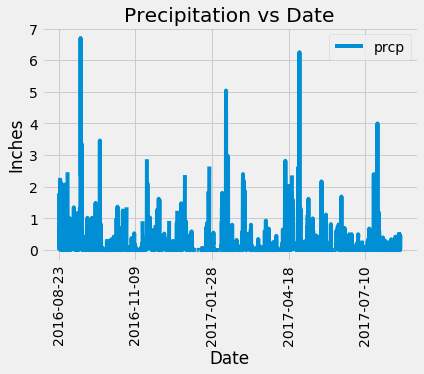

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()  
print(f' The last date in the dataset is {last_date} and thus the date one year before would be 2016-08-23')
 #calculating one year earlier as 2016-08-23 (which easy to observe)
# Perform a query to retrieve the data and precipitation scores
precipitation_date=session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= '2016-08-23').all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(precipitation_date, columns=['date', 'prcp'])
df=df.set_index('date')
# Sort the dataframe by date, seems to be already sorted byt just to make usre 
df=df.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax2=df.plot.line()
plt.xticks(rotation=90)
plt.title("Precipitation vs Date")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()


In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
#count by number of stations currently
#count the number of ids
count=session.query(func.count(station.id)).scalar()
print(f'There are {count} stations in the dataset')



There are 9 stations in the dataset


In [12]:
#group existing stations and counting them by the number of temperature observations  
table = [measurement.station, station.name]
join_query = session.query(*table, func.count(measurement.tobs)).\
filter(measurement.station == station.station).\
group_by(measurement.station).\
    order_by(func.count().desc()).all()

join_query

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [13]:
#from this it was obtained that the highest station count is USC00519281
station_highest=join_query[0]
print(station_highest)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
min = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()

print(f'The minimum temperature for station USC00519281 (WAIHEE 837.5) is {min}')

# highest temperature recorded, and average temperature of the most active station?
max = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()

print(f'The maximum temperature for station USC00519281 (WAIHEE 837.5) is {max}')


average = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()

print(f'The average temperature for station USC00519281 (WAIHEE 837.5) is {average}')




The minimum temperature for station USC00519281 (WAIHEE 837.5) is 54.0
The maximum temperature for station USC00519281 (WAIHEE 837.5) is 85.0
The average temperature for station USC00519281 (WAIHEE 837.5) is 71.66378066378067


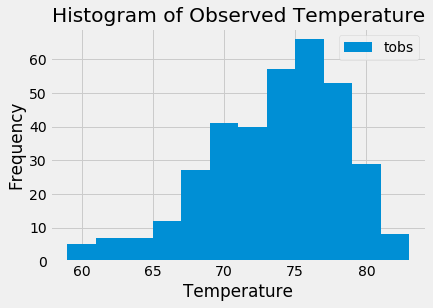

In [15]:
# Choose the station with the highest number of temperature observations.
#found before to be USC0051928



# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_active=session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= '2016-08-23').\
    filter(measurement.station == 'USC00519281').all()

df2=pd.DataFrame(station_active, columns=['date', 'tobs'])

df2=df2.set_index("date")

ax3=df2.plot.hist(bins=12)
plt.xticks(rotation=0)
plt.title("Histogram of Observed Temperature")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment - Temperature Analysis 1

In [16]:
#get average temperature for June of all years in dataset and store
Jun_avg=session.query(func.avg(measurement.tobs)).\
    filter(func.strftime("%m", measurement.date) == "06").scalar()

#Getting average for Decemeber 
Dec_avg=session.query(func.avg(measurement.tobs)).\
    filter(func.strftime("%m", measurement.date) == "12").scalar()

print(f'The June average is {Jun_avg}')
print(f'The December average is {Dec_avg}')


The June average is 74.94411764705882
The December average is 71.04152933421226


An independent/paired t-test is needed to see whether the difference between these two means are statistically significant. This t-test is needed because we are dealing with two set of data. 

In [17]:
#Need to calculate the standard error for June 

#convert both June results and the December results to a dataframe
June=session.query(measurement.date, measurement.tobs).\
    filter(func.strftime("%m", measurement.date) == "06").all()

June_db=pd.DataFrame(June, columns=["date", "tobs"])

Dec=session.query(measurement.date, measurement.tobs).\
    filter(func.strftime("%m", measurement.date) == "12").all()

Dec_db=pd.DataFrame(Dec, columns=["date", "tobs"])



In [18]:
#conducting the t-test (independent t-test)

stats.ttest_ind(June_db.tobs, Dec_db.tobs, equal_var=False)


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

As the p value is < 0.05, the independent t-test clearly indicates a statistically significant difference between the mean temperature of Hawaii in June and the mean temperature of Hawaii in December

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
temp_calc1=calc_temps('2011-02-28', '2011-03-05')
print(temp_calc1)
# for your trip using the previous year's data for those same dates.

#using the previous years compared to example


[(61.0, 69.75510204081633, 75.0)]


In [21]:
# Plot the results from your previous query as a bar chart. 
temp_db=pd.DataFrame(temp_calc1, columns=["TMin", "TAvg", "TMax"])
temp_db


,TMin,TAvg,TMax
0,61.0,69.755102,75.0


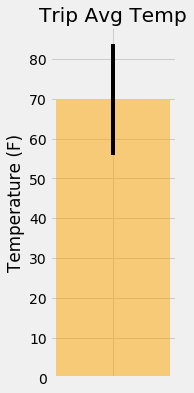

In [22]:
avg_temp = temp_db['TAvg']
max_temp = temp_db['TMax']
min_temp= temp_db['TMin']
 
x = np.arange(1,2)
width =0.1
plt.figure(figsize=(2,6))
plt.bar(x,avg_temp,width,linewidth=8,alpha=0.5, tick_label="", color="orange",yerr=(max_temp-min_temp))

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

plt.ylabel("Temperature (F)")
plt.savefig("Bar_chart_temp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching datest.
#Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

table = [measurement.station, station.name, station.latitude, station.longitude, station.elevation]
join_query = session.query(*table, func.sum(measurement.prcp)).\
filter(measurement.station == station.station).\
filter(measurement.date >= '2011-02-28').filter(measurement.date <= '2011-03-05').\
group_by(measurement.station).\
    order_by(func.sum(measurement.prcp).desc()).all()

join_query



[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.23),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("08-23")



[(67.0, 76.6923076923077, 87.0)]

In [25]:
# calculate the daily normals for your trip

# Set the start and end date of the trip is


#The start and end date of the trip is '2011-02-28' and '2011-03-05 as shown from before

# Use the start and end date to create a range of dates- I included start and end date

start = datetime.datetime.strptime("2011-02-28", "%Y-%m-%d")
end = datetime.datetime.strptime("2011-03-05", "%Y-%m-%d")
date_array = \
    (start + datetime.timedelta(days=x+1) for x in range(-1, (end-start).days))
 
# Stip off the year and save a list of %m-%d strings
   
date_list=[]
for date_object in date_array:
    date_list.append(date_object.strftime("%m-%d"))
    

# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`

normals=[]

for date in date_list:
    normals.append(daily_normals(date))

#Printing list of calculated daily normals
print(normals)

[[(65.0, 70.65517241379311, 80.0)], [(64.0, 70.0327868852459, 76.0)], [(61.0, 70.36666666666666, 78.0)], [(60.0, 70.06896551724138, 78.0)], [(57.0, 69.27272727272727, 77.0)], [(60.0, 67.89090909090909, 76.0)]]


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_final=pd.DataFrame([t for lst in normals for t in lst], columns=["tmin", "tavg", "tmax"])
data_final["date"]=date_list
data_final=data_final.set_index("date")
data_final



,tmin,tavg,tmax
date,,,
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


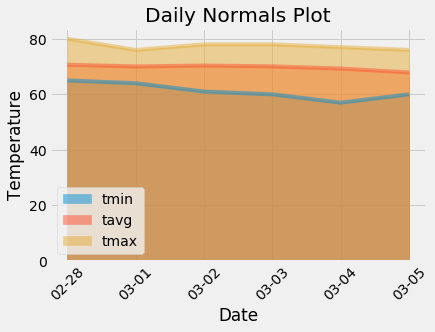

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
ax=data_final.plot.area(stacked=False)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Daily Normals Plot")
plt.xticks(rotation=45)

plt.show()